### Partition face dataset into 8:2 training:test

### Apply PCA on training data by use of eigenvectors and eigenvalues of covaraiance matrix S= (1/N)A(A^T)

### Apply PCA using eigenvectors and eigenvalues of (1/N)(A^T)A

In [2]:
# PCA source: Week 2 slides - Manifold Learning

import numpy as np
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

np.random.seed(42)

data = loadmat('face.mat')

X = data['X'] # flat images dim (2576,520)
# l = data['l'].flatten()  # image Labels (1,520)

# Does a 8/2 split of dataset (8 images / 2 images of each person). Training data shuffled. 
def Q1_partition(data):
    X = data['X'] # flat images dim (2576,520)
    X_train, X_test = [], []
    for i in range(0, 520, 10):
        im_train, im_test = train_test_split(X[:, i: i + 10].T, test_size=0.2, random_state=42)
        X_train.append(im_train)    
        X_test.append(im_test)  
  
    return  np.array(X_train).reshape(-1, 2576), np.array(X_test).reshape(-1, 2576)

In [ ]:
def display_image(image, label):
    # X[:, image_index]
    image_height, image_width = 46, 56 
    image = image.reshape((image_height, image_width)).T 
    # label = l[image_index]

    plt.imshow(image, cmap='gray', aspect='auto')
    plt.title(f"Face Image - Label: {label}")
    plt.axis('off')
    plt.show()
    # display_image(X_train[1:2].T, "hey")
    # display_image(t1[i:i+1].T, "Hey")

def get_sorted_eigen(M):
    eigenvalues, eigenvectors = np.linalg.eig(M)
    eigenvalues, eigenvectors = np.real(eigenvalues), np.real(eigenvectors)

    sorted_indices = np.argsort(eigenvalues)[::-1]

    sorted_eigenvalues = eigenvalues[sorted_indices]
    sorted_eigenvectors = eigenvectors[:, sorted_indices]
    
    return sorted_eigenvalues, sorted_eigenvectors

# S = Covariance Matrix, A = mean centred data, N = #samples
def PCA(batch, k = 120, inverter = 0):
    A, mean, S = process_batch(batch, inverter)
    eigenvalues, eigenvectors = get_sorted_eigen(S)
    #k = choose_principal_components(threshold, eigenvalues)
    
    if inverter :
        eigenvectors = np.dot(A.T, eigenvectors)
        
        
    return eigenvalues[:k + 1], eigenvectors[:, :k + 1] / np.linalg.norm(eigenvectors[:, :k + 1]), mean

def choose_principal_components(threshold, eigenvalues):
    covariance_ratios = eigenvalues/np.sum(eigenvalues)
    cum_var = 0
    for k, ratio in enumerate(covariance_ratios):
        cum_var += ratio
        if cum_var >= threshold: return k 

def process_batch(batch, inverter):
    mean = np.mean(batch, axis=0)
    A = batch - mean
    print(f'batch: {batch.shape}')
    print(f'A: {A.shape}')
    N = A.shape[1]
    
    if inverter :
        S = (1/N) * np.dot(A, A.T)
    else :
        S = (1/N) * np.dot(A.T, A)
        
    print(f'S: {S.shape}')
    print(f'Mean: {mean.shape}')
    return A, mean, S

In [ ]:
# S = Covariance Matrix, A = mean centred data, N = #samples per class, C = #classes
def LDA(batch, C, N, k = 120, inverter = 0):
    mean, SB, SW = process_batch_LDA(batch, C, N)
    eigenvalues, eigenvectors = get_sorted_eigen(np.linalg.inv(SW).dot(SB))
    #k = choose_principal_components(threshold, eigenvalues) 
        
    return eigenvalues[:k + 1], eigenvectors[:, :k + 1], mean

def process_batch_LDA(batch, C, N):
    print(f'batch: {batch.shape}')
    class_mean = np.array([np.mean(batch[i*N:(i+1)*N-1,:], axis=0) for i in range(C)])
    print(f'Class_mean: {class_mean.shape}') 
    mean = np.mean(class_mean, axis=0)
    print(f'Mean: {mean.shape}')
    
    SW = np.zeros((batch.shape[1], batch.shape[1]))
    for i, c_mean in enumerate(class_mean) :
        xn = batch[i*N:(i+1)*N-1,:] - c_mean
        for x in xn :
            SW += np.dot(x, x.T)
    print(f'SW: {SW.shape}')
    
    SB = np.zeros((batch.shape[1], batch.shape[1]))
    for c_mean in class_mean :
        SB += N * np.dot((c_mean - mean), (c_mean - mean).T)    
    print(f'SB: {SB.shape}')
        
    
    return mean, SW, SB

In [28]:
# They cannot possibly be the same since they have different dimensions. 
X_train, X_test = Q1_partition(data)
##### Look here FELIX - AAT: S = (1/N) A * A^T, ATA: S = (1/N) A^T * A  
#eigenvalues_AAT, eigenvectors_AAT, mean = PCA(X_train, 120)
#eigenvalues_ATA, eigenvectors_ATA, mean = PCA(X_train, 120, 1)
##########
eigenvalues, eigenvectors, mean = LDA(X_train, 52, 8, 120)


batch: (416, 2576)
Class_mean: (52, 2576)
Mean: (2576,)
SW: (2576, 2576)
SB: (2576, 2576)


In [29]:
print(eigenvectors.shape)
print(np.sum(eigenvectors))
print(eigenvectors[0])

(2576, 121)
-50.75431016179731
[-1.97027602e-02 -6.30759597e-01  3.12245359e-06 -2.70881629e-12
 -8.86854003e-13  3.93468377e-13 -3.07802213e-13 -3.07802213e-13
  4.31104779e-13  4.28962628e-13  3.83051741e-13  3.83051741e-13
  9.07345264e-13  1.03988805e-12 -3.76476452e-13 -1.65597453e-13
  1.21146298e-13  1.21146298e-13 -3.40545414e-14  5.24858016e-14
  5.24858016e-14 -1.36818022e-13 -1.36818022e-13  3.97807129e-14
  1.39654453e-14  1.39654453e-14  9.00986619e-15  2.71095279e-14
 -4.55667391e-14 -4.55667391e-14 -5.12395868e-15 -5.12395868e-15
 -7.46347719e-15  7.75059277e-16  5.71282032e-15  5.71282032e-15
  7.19944342e-15  7.19944342e-15  2.17405551e-15  2.17405551e-15
  8.27151125e-15 -3.53890512e-15 -3.53890512e-15  1.97525677e-14
  1.97525677e-14  5.31926427e-15 -1.55680987e-14 -1.55680987e-14
 -1.99592749e-14  1.02326759e-14  1.27026016e-14  1.27026016e-14
 -5.88965269e-15 -5.88965269e-15 -1.11261535e-14 -1.11261535e-14
 -4.20607167e-16 -4.20607167e-16 -1.51571551e-14 -1.5157155

In [32]:
def deconstruct(image, eigenvects, mean):
    #Project and image on the eigenvectors
    
    reduced = image - mean
    projected = np.zeros((eigenvects.shape[1]))
    for i, vector in enumerate(eigenvects.T) :
        projected[i] = np.dot(reduced, vector)
    return projected

def reconstruct(projected, eigenvects, mean) :  
    #Reconstruct an image from its projection
          
    return mean + np.sum((eigenvects * projected), axis=1)

def test_image(img, eigenvects, mean, display=0):
    #Returns norm of reconstruction error, can display images
    
    projected = deconstruct(img, eigenvects, mean)
    re_image = reconstruct(projected, eigenvects, mean)
    
    if display :
        display_image(img, "Image 4")
        display_image(re_image, "Image 4 after reconstruct")
    return(np.linalg.norm(img-re_image))
    
   
print(test_image(X[:, 3], eigenvectors, mean, 0))
print(np.mean([test_image(X[:, i], eigenvectors, mean, 0) for i in range(len(X[0]))]))  #mean error


1607.0045549295799
2879.5604440647653


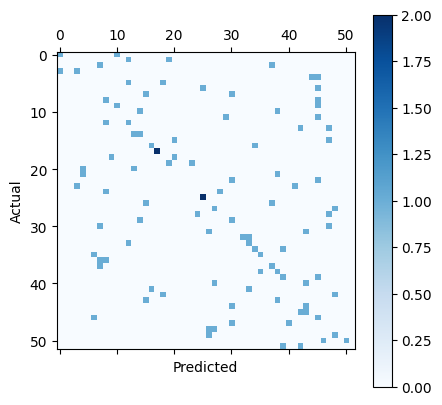

Accuracy :  0.19230769230769232


In [33]:
def testing_NN(image, projections, eigenvects, mean) :
    #Finds which training image correspond best to this image
    
    projected = deconstruct(image, eigenvects, mean)
    return np.argmin(np.linalg.norm((projections - projected), axis=1))

def fulltest(X_test, X_train, eigenvects, mean):
    #Compute all testing images and return guessed label
    
    projections = np.array([deconstruct(X_train[i], eigenvects, mean) for i in range(len(X_train))])
    res = []
    for image in X_test:
        res.append((testing_NN(image, projections, eigenvects, mean) //8) + 1)
    return np.array(res)

res = fulltest(X_test, X_train, eigenvectors, mean)
labels = np.array([j+1 for j in range(52) for i in range(2)])

cm = confusion_matrix(labels, res)

plt.matshow(cm, cmap = 'Blues')
plt.colorbar()
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

print("Accuracy : ", sum(np.equal(res, labels))/len(res))